In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
plt.rcParams['figure.figsize'] = 8,8

import time

from numpy.linalg import norm
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *

from tensorflow.keras.utils import *

from tensorflow.keras.regularizers import *
#import keras
import numpy as np
import os, math
from matplotlib.pyplot import figure
#from keras.backend import tensorflow_backend
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.metrics import structural_similarity as ssim
import math
from  sklearn.model_selection import train_test_split

#from tensorflow.python import debug as tf_debug
import imageio
import glob
from skimage import transform as tf
 


from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import scipy
import scipy
import skimage
import re
#import LRFinder
import math as m
import tensorflow as tf  
from pathlib import Path
 

 

import numpy as np
 
 
 

import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

tf.random.Generator = None 
 
 

import warnings
warnings.filterwarnings('ignore')
 

from datetime import datetime
from scipy.fftpack import dct, idct
import copy

 

from numpy import linalg as la

 

2022-09-21 13:51:37.172452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 13:51:37.703636: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2022-09-21 13:51:37.703678: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2022-09-21 13:51:37.703684: W tensorflow/compiler/tf2tensorrt/utils/py_utils

# Change here and select your preferred Dataset

In [2]:
(x_train, y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
#(x_train, y_train), (X_test, Y_test) = tf.keras.datasets.cifar100.load_data()

In [3]:
print(len(x_train), len(y_train),  len(X_test), len(Y_test))

50000 50000 10000 10000


In [4]:
 

y_train = to_categorical(y_train)
Y_test = to_categorical(Y_test)

y_train = y_train[0:len(x_train)] 
Y_test=  Y_test [0:len(X_test)] 


print(y_train.shape, Y_test.shape)

(50000, 10) (10000, 10)


In [5]:
image_size = x_train.shape[1]

x_train = np.reshape(x_train,[-1, image_size, image_size, 3])
X_test = np.reshape(X_test,[-1, image_size, image_size, 3])

x_train = x_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print(x_train.shape, X_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [6]:
 
x_val=X_test[:3000]
y_val=Y_test[:3000]
x_test=X_test[3001:]
y_test=Y_test[3001:]

In [7]:
# network parameters
input_shape = (image_size, image_size, 3)
 
kernel_size = 3
filters = 64
dropout = 0.3

## Networks and modules

In [8]:
def conv_block(units, dropout=0.2, activation='relu', block=1, layer=1):

    def layer_wrapper(inp):
        x = Conv2D(units, (3, 3), padding='same' ,kernel_initializer='he_normal', name='block{}_conv{}'.format(block, layer))(inp)
        x = BatchNormalization(name='block{}_bn{}'.format(block, layer))(x)
        x = Activation(activation, name='block{}_act{}'.format(block, layer))(x)
        x = Dropout(dropout, name='block{}_dropout{}'.format(block, layer))(x)
        return x

    return layer_wrapper

def dense_block(units, dropout=0.2, activation='relu', name='fc1'):

    def layer_wrapper(inp):
        x = Dense(units,kernel_initializer='he_normal', name=name)(inp)
        x = BatchNormalization(name='{}_bn'.format(name))(x)
        x = Activation(activation, name='{}_act'.format(name))(x)
        x = Dropout(dropout, name='{}_dropout'.format(name))(x)
        return x

    return layer_wrapper
        

def VGG16_BN(input_tensor=None, input_shape=None, classes=1000, conv_dropout=0.1, dropout=0.3, activation='relu'):
    """Instantiates the VGG16 architecture with Batch Normalization
    # Arguments
        input_tensor: Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
        input_shape: shape tuple
        classes: optional number of classes to classify images
    # Returns
        A Keras model instance.
    """
    img_input = Input(shape=input_shape) if input_tensor is None else (
        Input(tensor=input_tensor, shape=input_shape) if not K.is_keras_tensor(input_tensor) else input_tensor
    )

    # Block 1
    x = conv_block(32, dropout=conv_dropout, activation=activation  , block=1, layer=1)(img_input)
    x = conv_block(32, dropout=conv_dropout, activation=activation  , block=1, layer=2)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = conv_block(64, dropout=conv_dropout, activation=activation  , block=2, layer=1)(x)
    x = conv_block(64, dropout=conv_dropout, activation=activation  , block=2, layer=2)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = conv_block(128, dropout=conv_dropout, activation=activation , block=3, layer=1)(x)
    x = conv_block(128, dropout=conv_dropout, activation=activation , block=3, layer=2)(x)
    x = conv_block(128, dropout=conv_dropout, activation=activation , block=3, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = conv_block(256, dropout=conv_dropout, activation=activation,  block=4, layer=1)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation,  block=4, layer=2)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation,  block=4, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = conv_block(256, dropout=conv_dropout, activation=activation,  block=5, layer=1)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation,  block=5, layer=2)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation,  block=5, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Flatten
    x = GlobalAveragePooling2D()(x)

    # FC Layers
    x = dense_block(512, dropout=dropout, activation=activation ,  name='fc1')(x)
    x = dense_block(512, dropout=dropout, activation=activation , name='fc2')(x)
    
    # Classification block    
    x = Dense(classes, activation='relu' )(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    inputs = get_source_inputs(input_tensor) if input_tensor is not None else img_input

    # Create model.
    return Model(inputs, x, name='vgg16_bn')





def InceptionResNetModule(input_shapee, n_filters, kernel_size):
    seed=32
    path_a = Conv2D(filters=n_filters/32, kernel_size=(3,3), padding='same',
               kernel_initializer=tf.keras.initializers.he_normal(seed=seed))(input_shapee)
    path_a = BatchNormalization(axis=-1)(path_a)
    path_a = Activation('elu')(path_a)

    path_b = Conv2D(filters=n_filters, kernel_size=kernel_size, padding='same',
               kernel_initializer=tf.keras.initializers.he_normal(seed=seed))(input_shapee)
    path_b = BatchNormalization(axis=-1)(path_b)
    path_b = Activation('elu')(path_b)

    path_b = Conv2D(filters=n_filters, kernel_size=kernel_size, padding='same',
               kernel_initializer=tf.keras.initializers.he_normal(seed=seed))(path_b)
    path_b = BatchNormalization(axis=-1)(path_b)

    shortcut = Conv2D(filters=n_filters, kernel_size=(3,3),  activation='elu', padding='same',
               kernel_initializer=tf.keras.initializers.he_normal(seed=seed))(input_shapee)
    shortcut = BatchNormalization(axis=-1)(shortcut)
    shortcut = Activation('elu')(shortcut)

    path_b = Activation('elu')(add([shortcut, path_b]))

    path_c = Conv2D(filters=n_filters/32, kernel_size=(3, 3), padding='same',
                    kernel_initializer=tf.keras.initializers.he_normal(seed=seed))(input_shapee)
    path_c = BatchNormalization(axis=-1)(path_c)
    path_c = Activation('elu')(path_c)

    output = concatenate([path_a, path_b, path_c])

    output = MaxPooling2D(pool_size=(2, 2))(output)
    y = Dropout(0.2)(output)

    return y


def cir(input_shape,  classes=Y_test.shape[1]):
    inputs = Input(shape=(input_shape))
    kernel_size = (3,3)
    y = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer=tf.keras.initializers.he_normal(seed=32))(inputs)
    y = InceptionResNetModule(y, 32, kernel_size)
    y = InceptionResNetModule(y, 64, kernel_size)
    y = InceptionResNetModule(y, 64, kernel_size)
    y = Flatten()(y)
    y = Dropout(0.2)(y)
    y = Dense(128, activation='elu')(y)
    y = Dropout(0.2)(y)
    y = Dense(classes, activation='relu' )(y)
    outputs = Dense(classes, activation='softmax')(y)
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

def noz(x):
    x=np.asarray(x)
    return (x-x.min())/(x.max()-x.min())


def noma(x):
    return (x-K.min(x))/(K.max(x)-K.min(x))



def ResidualBlock(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        # residual_x = conv2d_bn_relu(x, filters, kernel_size=1, strides=2)
        residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              weight_decay=weight_decay,
                              strides=stride,
                              )
    residual = conv2d_bn(residual,
                         filters=filters,
                         kernel_size=kernel_size,
                         weight_decay=weight_decay,
                         strides=1,
                         )
    out =  add([residual_x, residual])
    out = Activation('relu')(out)
    return out



def conv2d_bn(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   use_bias=False,
                   kernel_regularizer=l2(weight_decay)
                   )(x)
    layer = BatchNormalization()(layer)
    return layer


def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = conv2d_bn(x, filters, kernel_size, weight_decay, strides)
    layer = Activation('relu')(layer)
    return layer



def ResNet18(classes, input_shape, weight_decay=1e-4):
    input = Input(shape=input_shape)
    x = input
    # x = conv2d_bn_relu(x, filters=64, kernel_size=(7, 7), weight_decay=weight_decay, strides=(2, 2))
    # x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),  padding='same')(x)
    x = conv2d_bn_relu(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 5
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='relu')(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name='ResNet18')
    return model


def ResNetForCIFAR10(classes, name, input_shape, block_layers_num=5, weight_decay=1e-5):
    input = Input(shape=input_shape)
    x = input
    x = conv2d_bn_relu(x, filters=8, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    for i in range(block_layers_num):
        x = ResidualBlock(x, filters=8, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=32, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    for i in range(block_layers_num - 1):
        x = ResidualBlock(x, filters=32, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    for i in range(block_layers_num - 1):
        x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(8, 8), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='relu')(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name=name)
    return model



def densenet(input_shape,classes_num):
    growth_rate        = 3
    depth              = 100
    compression        = 0.5
    img_input =   Input(shape=(input_shape))
    def conv(x, out_filters, k_size):
        return Conv2D(filters=out_filters,
                      kernel_size=k_size,
                      strides=(1,1),
                      padding='same',
                      kernel_initializer='he_normal',
                      use_bias=False)(x)

    def dense_layer(x):
        return Dense(units=classes_num,
                     activation='softmax',
                     kernel_initializer='he_normal')(x)

    def bn_relu(x):
        x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
        x = Activation('relu')(x)
        return x

    def bottleneck(x):
        channels = growth_rate * 4
        x = bn_relu(x)
        x = conv(x, channels, (1,1))
        x = bn_relu(x)
        x = conv(x, growth_rate, (3,3))
        return x

    def single(x):
        x = bn_relu(x)
        x = conv(x, growth_rate, (3,3))
        return x

    def transition(x, inchannels):
        outchannels = int(inchannels * compression)
        x = bn_relu(x)
        x = conv(x, outchannels, (1,1))
        x = AveragePooling2D((2,2), strides=(2, 2))(x)
        return x, outchannels

    def dense_block(x,blocks,nchannels):
        concat = x
        for i in range(blocks):
            x = bottleneck(concat)
            concat = concatenate([x,concat], axis=-1)
            nchannels += growth_rate
        return concat, nchannels


    nblocks = (depth - 4) // 6 
    nchannels = growth_rate * 2


    x = conv(img_input, nchannels, (3,3))
    x, nchannels = dense_block(x,nblocks,nchannels)
    x, nchannels = transition(x,nchannels)
    x, nchannels = dense_block(x,nblocks,nchannels)
    x, nchannels = transition(x,nchannels)
    x, nchannels = dense_block(x,nblocks,nchannels)
    x = bn_relu(x)
    x = GlobalAveragePooling2D()(x)
    x = dense_layer(x)
    model = Model(img_input, x)
    return model


In [9]:
 


 

    
image_size=32    
filters=256    
patch_size=2
kernel_size=5
depth=8
num_classes=Y_test.shape[1]

 
     

In [10]:
# network parameters
 

kernel_size = 3
filters = 32
dropout = 0.3
 

inputs = Input(shape=input_shape)

 

def clsclb(input_shape,  classes=Y_test.shape[1], conv_dropout=0.1, ):
    inputs = Input(shape=(input_shape))
    filters = 64
    y = Conv2D(filters=filters,kernel_size=kernel_size,strides=1,activation='relu',kernel_initializer='he_normal')(inputs)
    y = MaxPooling2D()(y)
    y = BatchNormalization(axis=-1)(y)
    y = Conv2D(filters=filters,kernel_size=kernel_size,strides=1,activation='relu',kernel_initializer='he_normal')(y)
    y = MaxPooling2D()(y)
    y = BatchNormalization(axis=-1)(y)
    y = Conv2D(filters=filters,kernel_size=kernel_size,strides=1,activation='relu',kernel_initializer='he_normal')(y)
    y = BatchNormalization(axis=-1)(y)
    y = Flatten()(y)
 
    y = Dropout(dropout)(y)
    y= Dense(512, activation='relu')(y)
    y = BatchNormalization(axis=-1)(y)
    y= Dense(64, activation='relu')(y)
    y = BatchNormalization(axis=-1)(y)
    y= Dense(10, activation='relu')(y)
    outputs = Dense(classes, activation='softmax')(y)
    model = Model(inputs=inputs, outputs=outputs)
    return model
 
    
def plot_sample(lr, sr):
    plt.figure(figsize=(4, 3))

    images = [lr, sr]
    titles = ['denoised', 'noisy']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    
 

 

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.models import Model


# Change here and select model

In [12]:
ms = 1

 
if ms==1:
    model    =      clsclb(input_shape)
    fw       =      model.get_weights()
    modelo   =      clsclb(input_shape) 
    modelc   =      clsclb(input_shape) 
    modele   =      clsclb(input_shape)
    modelo.set_weights(fw) 
    modelc.set_weights(fw) 
    ud= 7
    
    
    
elif ms==2:
    model  =  VGG16_BN(input_tensor=None, input_shape=x_train.shape[1:], classes=Y_test.shape[1], conv_dropout=0.1, dropout=0.3, activation='relu')
    fw     =  model.get_weights()
    modelo =  VGG16_BN(input_tensor=None, input_shape=x_train.shape[1:], classes=Y_test.shape[1], conv_dropout=0.1, dropout=0.3, activation='relu')
    modelc =  VGG16_BN(input_tensor=None, input_shape=x_train.shape[1:], classes=Y_test.shape[1], conv_dropout=0.1, dropout=0.3, activation='relu')
    modele =  VGG16_BN(input_tensor=None, input_shape=x_train.shape[1:], classes=Y_test.shape[1], conv_dropout=0.1, dropout=0.3, activation='relu')
    modelo.set_weights(fw) 
    modelc.set_weights(fw) 
    ud= 53

elif ms==3:
    model  =  cir(input_shape,Y_test.shape[1])
    fw     =  model.get_weights()
    modelo =  cir(input_shape,Y_test.shape[1])
    modelc =  cir(input_shape,Y_test.shape[1])
    modele =  cir(input_shape,Y_test.shape[1])
    modelo.set_weights(fw) 
    modelc.set_weights(fw) 
    ud= 49
    
elif ms==4:
    model    =      ResNetForCIFAR10(num_classes , 'resnet56', input_shape )
    fw       =      model.get_weights()
    modelo   =      ResNetForCIFAR10(num_classes , 'resnet56', input_shape )
    modelc   =      ResNetForCIFAR10(num_classes , 'resnet56', input_shape )
    modele   =      ResNetForCIFAR10(num_classes , 'resnet56', input_shape )                       
    modelo.set_weights(fw) 
    modelc.set_weights(fw) 
    ud= 109
    
 

2022-09-21 13:51:39.163085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 13:51:39.184495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 13:51:39.184618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 13:51:39.185075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [13]:
#modelc.set_weights(fw)  

## Cutmix

In [14]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    IMG_SIZE =32
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two
    IMG_SIZE = image1.shape[0]
    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label


AUTO = tf.data.AUTOTUNE

 


## augmentation function
def uxdata(X_traina, y_traina, X_val, y_val, bzs):
 
 
    train_ds_one =  tf.data.Dataset.from_tensor_slices((X_traina, y_traina)).shuffle(1024)
    train_ds_two = tf.data.Dataset.from_tensor_slices((X_traina, y_traina)).shuffle(1024)   
    train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))               
     
    train_dataset= (
    train_ds.shuffle(1024).map(cutmix, num_parallel_calls=AUTO).batch(bzs).prefetch(AUTO))               
                    
                    

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(bzs)
    
    return train_dataset, val_dataset



 

In [15]:
 


train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric   = tf.keras.metrics.CategoricalAccuracy() 

## supporting functions

In [16]:


## add gradients/prarameters 
def agy(parameters, gradients ):
    new_grads = []
    for (params, grads) in zip(parameters, gradients):
 
        ap = 5e-1
        gt = (grads)  +(params)
        new_grads.append( (gt)  )
    return new_grads  





## add noise to the last layer

def gnl(gradis):
    cgrads = []
    for i in range(len(gradis)):
        grad = gradis[i]
        if i== len(gradis)-1:
            rv=  (tf.random.normal(grad.shape, mean=0.0, stddev=1e-1, dtype=tf.dtypes.float32))
            grad = grad*rv
            
        cgrads.append(grad)
    return cgrads



## add noise to each layer

def gna(gradis):
    cgrads = []
    for grad in gradis:
        rank = len(grad.shape)
        if rank > 1:
            rv=  (tf.random.normal(grad.shape, mean=0.0, stddev=1e-4, dtype=tf.dtypes.float32))
            grad = grad+rv
        cgrads.append(grad)
    return cgrads 





## add noise to salient layer



def gnsn(gradis,yd):
    cgrads = []
    for i in range(len(gradis)):
        grad = gradis[i]
        if i== yd:
            rv=  (tf.random.normal(grad.shape, mean=0.0, stddev=1e-1, dtype=tf.dtypes.float32))
            grad = grad+rv
            
        cgrads.append(grad)
    return cgrads




## gradient centralization
 

def gc(gradis):
    cgrads = []
    for grad in gradis:
        rank = len(grad.shape)
        if rank > 1:
            grad -= tf.reduce_mean(grad, axis=list(range(rank-1)))
        cgrads.append(grad)
    return cgrads



## adaptive gradient clipping


def AGCO(parameters, gradients, clip_factor=0.01,
                       eps=1e-3):
    new_grads = []
    for (params, grads) in zip(parameters, gradients):
        p_norm = unitwise_norm(params)
        max_norm = tf.math.maximum(p_norm, eps) * clip_factor
        grad_norm = unitwise_norm(grads)
        clipped_grad = grads * (max_norm / tf.math.maximum(grad_norm, 1e-6))
        new_grad = tf.where(grad_norm < max_norm, grads, clipped_grad)
        new_grads.append(new_grad)
    return new_grads
    
def compute_norm(x, axis, keepdims):
    return tf.math.reduce_sum( abs(x)**2 , axis=axis, keepdims=keepdims) ** .5

def unitwise_norm(x):
    if len(x.get_shape()) <= 1:  # Scalars and vectors
        axis = None
        keepdims = False
    elif len(x.get_shape()) in [2, 3]:  # Linear layers of shape IO or multihead linear
        axis = 0
        keepdims = True
    elif len(x.get_shape()) == 4:  # Conv kernels of shape HWIO
        axis = [0, 1, 2,]
        keepdims = True
    else:
        raise ValueError(f"Got a parameter with shape not in [1, 2, 4]! {x}")
    return compute_norm(x, axis, keepdims)

In [17]:
kld = tf.keras.losses.KLDivergence()
 

## Baseline studies

In [18]:




def train_setup_baseline(tx_data,vl_data,model,epc,tid):
    
    train_dataset = tx_data
    val_dataset = vl_data
    
    #model = tf.keras.models.experimental.SharpnessAwareMinimization(model, rho=0.05, num_batch_splits=None, name=None)
    
    epochs = epc
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)  
    kld = tf.keras.losses.KLDivergence()
    
    
    fwo = model.get_weights()
    
    auwt = list()
    auwt.append(fwo)
    
    val_sc = list()
    tr_ac_hi=[]
    val_ac_hi=[]
    
    
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()
        
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(1e-4, decay_steps=1000, decay_rate=0.9) 
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            
            with tf.GradientTape(persistent = True) as tape:
                    
                    
                    xm = x_batch_train   
                    
                    ym = y_batch_train
                    
                    
                    logito = model(xm, training=True)
                    loss_valuo =   loss_fn(ym,  (logito)) 
                    
            grams = tape.gradient(loss_valuo , (model.trainable_weights)) 
            optimizer.apply_gradients(zip( (grams),   ( model.trainable_weights)   ))
 
    
            # Update training metric.
            train_acc_metric.update_state(y_batch_train, logito)

            # Display metrics at the end of each epoch.
            train_acc = train_acc_metric.result()
            
            
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            # Update val metrics
            val_acc_metric.update_state(y_batch_val, val_logits)
        
        
        val_acc = val_acc_metric.result()
            
        val_loss_value = loss_fn(y_batch_val, val_logits)
    
        tr_ac_hi.append("%.3f" % float(train_acc_metric.result()))
        val_ac_hi.append("%.3f" % float(val_acc_metric.result()))
        
        template = 'ETA: {} - epoch: {} loss: {}  acc: {} val loss: {} val acc: {}\n'
        print(template.format(round((time.time() -  start_time)/60, 2), epoch + 1,
                     "%.3f" %  loss_valuo, "%.3f" % float(train_acc_metric.result()),
                              "%.3f" % val_loss_value, "%.3f" % float(val_acc_metric.result())))
    
        vsd = val_loss_value
        val_sc.append(vsd)
        
        
        val_acc_metric.reset_states()
        train_acc_metric.reset_states()
 
        print("At setup "+ str(tid)+ " taken Time is : %.2fs" % (time.time() - start_time)) 
           
        if epoch>=3 and vsd<np.sort(val_sc)[1]:
            auwt[0] = model.get_weights()
            print('Best weight saved')
 


    return  auwt



def train_setup_gc(tx_data,vl_data,model,epc,tid):
    
    train_dataset = tx_data
    val_dataset = vl_data
    
    epochs = epc
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)  
    kld = tf.keras.losses.KLDivergence()
    
    
    fwo = model.get_weights()
    
    auwt = list()
    auwt.append(fwo)
    
    val_sc = list()
    tr_ac_hi=[]
    val_ac_hi=[]
    
    
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()
        
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(1e-4, decay_steps=1000, decay_rate=0.9) 
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            
            with tf.GradientTape(persistent = True) as tape:
                    
                    
                    xm = x_batch_train   
                    
                    ym = y_batch_train
                    
                    
                    logito = model(xm, training=True)
                    loss_valuo =   loss_fn(ym,  (logito)) 
                    
            grams = tape.gradient(loss_valuo , (model.trainable_weights)) 
            optimizer.apply_gradients(zip( gc(grams),   ( model.trainable_weights)   ))
 
    
            # Update training metric.
            train_acc_metric.update_state(y_batch_train, logito)

            # Display metrics at the end of each epoch.
            train_acc = train_acc_metric.result()
            
            
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            # Update val metrics
            val_acc_metric.update_state(y_batch_val, val_logits)
        
        
        val_acc = val_acc_metric.result()
            
        val_loss_value = loss_fn(y_batch_val, val_logits)
    
        tr_ac_hi.append("%.3f" % float(train_acc_metric.result()))
        val_ac_hi.append("%.3f" % float(val_acc_metric.result()))
        
        template = 'ETA: {} - epoch: {} loss: {}  acc: {} val loss: {} val acc: {}\n'
        print(template.format(round((time.time() -  start_time)/60, 2), epoch + 1,
                     "%.3f" %  loss_valuo, "%.3f" % float(train_acc_metric.result()),
                              "%.3f" % val_loss_value, "%.3f" % float(val_acc_metric.result())))
    
        vsd = val_loss_value
        val_sc.append(vsd)
        
        
        val_acc_metric.reset_states()
        train_acc_metric.reset_states()
 
        print("At setup "+ str(tid)+ " taken Time is : %.2fs" % (time.time() - start_time)) 
           
        if epoch>=3 and vsd<np.sort(val_sc)[1]:
            auwt[0] = model.get_weights()
            print('Best weight saved')
 


    return  auwt



def train_setup_agc(tx_data,vl_data,model,epc,tid):
    
    train_dataset = tx_data
    val_dataset = vl_data
    
    epochs = epc
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)  
    kld = tf.keras.losses.KLDivergence()
    
    
    fwo = model.get_weights()
    
    auwt = list()
    auwt.append(fwo)
    
    val_sc = list()
    tr_ac_hi=[]
    val_ac_hi=[]
    
    
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()
        
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(1e-4, decay_steps=1000, decay_rate=0.9) 
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            
            with tf.GradientTape(persistent = True) as tape:
                    
                    
                    xm = x_batch_train   
                    
                    ym = y_batch_train
                    
                    
                    logito = model(xm, training=True)
                    loss_valuo =   loss_fn(ym,  (logito)) 
                    
            grams = tape.gradient(loss_valuo , (model.trainable_weights)) 
            #grams = pgy(gna ( grams),grams)     
            grams = (AGCO(model.trainable_weights, grams)) 
            
            optimizer.apply_gradients(zip( (grams),   ( model.trainable_weights)   ))
 
    
            # Update training metric.
            train_acc_metric.update_state(y_batch_train, logito)

            # Display metrics at the end of each epoch.
            train_acc = train_acc_metric.result()
            
            
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            # Update val metrics
            val_acc_metric.update_state(y_batch_val, val_logits)
        
        
        val_acc = val_acc_metric.result()
            
        val_loss_value = loss_fn(y_batch_val, val_logits)
    
        tr_ac_hi.append("%.3f" % float(train_acc_metric.result()))
        val_ac_hi.append("%.3f" % float(val_acc_metric.result()))
        
        template = 'ETA: {} - epoch: {} loss: {}  acc: {} val loss: {} val acc: {}\n'
        print(template.format(round((time.time() -  start_time)/60, 2), epoch + 1,
                     "%.3f" %  loss_valuo, "%.3f" % float(train_acc_metric.result()),
                              "%.3f" % val_loss_value, "%.3f" % float(val_acc_metric.result())))
    
        vsd = val_loss_value
        val_sc.append(vsd)
        
        
        val_acc_metric.reset_states()
        train_acc_metric.reset_states()
 
        print("At setup "+ str(tid)+ " taken Time is : %.2fs" % (time.time() - start_time)) 
           
        if epoch>=3 and vsd<np.sort(val_sc)[1]:
            auwt[0] = model.get_weights()
            print('Best weight saved')
 


    return  auwt

def train_setup_agc_gc(tx_data,vl_data,model,epc,tid):
    
    train_dataset = tx_data
    val_dataset = vl_data
    
    epochs = epc
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)  
    kld = tf.keras.losses.KLDivergence()
    
    
    fwo = model.get_weights()
    
    auwt = list()
    auwt.append(fwo)
    
    val_sc = list()
    tr_ac_hi=[]
    val_ac_hi=[]
    
    
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()
        
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(1e-4, decay_steps=1000, decay_rate=0.9) 
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            
            with tf.GradientTape(persistent = True) as tape:
                    
                    
                    xm = x_batch_train   
                    
                    ym = y_batch_train
                    
                    
                    logito = model(xm, training=True)
                    loss_valuo =   loss_fn(ym,  (logito)) 
                    
            grams = tape.gradient(loss_valuo , (model.trainable_weights)) 
            grams = pgy(gna ( grams),grams)     
            #grams = gc(AGCO(model.trainable_weights, grams)) 
            
            optimizer.apply_gradients(zip( (grams),   ( model.trainable_weights)   ))
 
    
            # Update training metric.
            train_acc_metric.update_state(y_batch_train, logito)

            # Display metrics at the end of each epoch.
            train_acc = train_acc_metric.result()
            
            
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            # Update val metrics
            val_acc_metric.update_state(y_batch_val, val_logits)
        
        
        val_acc = val_acc_metric.result()
            
        val_loss_value = loss_fn(y_batch_val, val_logits)
    
        tr_ac_hi.append("%.3f" % float(train_acc_metric.result()))
        val_ac_hi.append("%.3f" % float(val_acc_metric.result()))
        
        template = 'ETA: {} - epoch: {} loss: {}  acc: {} val loss: {} val acc: {}\n'
        print(template.format(round((time.time() -  start_time)/60, 2), epoch + 1,
                     "%.3f" %  loss_valuo, "%.3f" % float(train_acc_metric.result()),
                              "%.3f" % val_loss_value, "%.3f" % float(val_acc_metric.result())))
    
        vsd = val_loss_value
        val_sc.append(vsd)
        
        
        val_acc_metric.reset_states()
        train_acc_metric.reset_states()
 
        print("At setup "+ str(tid)+ " taken Time is : %.2fs" % (time.time() - start_time)) 
           
        if epoch>=3 and vsd<np.sort(val_sc)[1]:
            auwt[0] = model.get_weights()
            print('Best weight saved')
 


    return  auwt


def train_setup_sam(tx_data,vl_data,model,epc,tid):
    
    train_dataset = tx_data
    val_dataset = vl_data
    
    epochs = epc
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)  
    kld = tf.keras.losses.KLDivergence()
    
    
    fwo = model.get_weights()
    
    auwt = list()
    auwt.append(fwo)
    
    val_sc = list()
    tr_ac_hi=[]
    val_ac_hi=[]
    
    
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()
        
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(1e-4, decay_steps=1000, decay_rate=0.9) 
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            
            with tf.GradientTape(persistent = True) as tape:
                    
                    
                    xm = x_batch_train   
                    
                    ym = y_batch_train
                    
                    
                    logito = model(xm, training=True)
                    loss_valuo =   loss_fn(ym,  (logito)) 
                    
            grams = tape.gradient(loss_valuo , (model.trainable_weights)) 
            
            rho=0.05
            eps=1e-12
            e_ws = []
                
            grad_norm = tf.linalg.global_norm(grams)
            ew_multiplier = rho / (grad_norm + eps)
                
            for i in range(len(model.trainable_weights)):
                    
                    e_w = tf.math.multiply(grams[i], ew_multiplier)
                    
                    model.trainable_weights[i].assign_add(e_w)
                    e_ws.append(e_w)     
                    
            with tf.GradientTape(persistent = True) as tape:

                    logit1 = model(xm, training=True)
                    
                    loss_valu1 =   loss_fn(ym,  (logit1)) 
                    
            grams = tape.gradient(loss_valu1 , (model.trainable_weights)) 
                
            for i in range(len(model.trainable_weights)):
                        
                        model.trainable_weights[i].assign_sub(e_ws[i])

            
            
            optimizer.apply_gradients(zip( (grams),   ( model.trainable_weights)   ))
 
    
            # Update training metric.
            train_acc_metric.update_state(y_batch_train, logito)

            # Display metrics at the end of each epoch.
            train_acc = train_acc_metric.result()
            
            
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            # Update val metrics
            val_acc_metric.update_state(y_batch_val, val_logits)
        
        
        val_acc = val_acc_metric.result()
            
        val_loss_value = loss_fn(y_batch_val, val_logits)
    
        tr_ac_hi.append("%.3f" % float(train_acc_metric.result()))
        val_ac_hi.append("%.3f" % float(val_acc_metric.result()))
        
        template = 'ETA: {} - epoch: {} loss: {}  acc: {} val loss: {} val acc: {}\n'
        print(template.format(round((time.time() -  start_time)/60, 2), epoch + 1,
                     "%.3f" %  loss_valuo, "%.3f" % float(train_acc_metric.result()),
                              "%.3f" % val_loss_value, "%.3f" % float(val_acc_metric.result())))
    
        vsd = val_loss_value
        val_sc.append(vsd)
        
        
        val_acc_metric.reset_states()
        train_acc_metric.reset_states()
 
        print("At setup "+ str(tid)+ " taken Time is : %.2fs" % (time.time() - start_time)) 
           
        if epoch>=3 and vsd<np.sort(val_sc)[1]:
            auwt[0] = model.get_weights()
            print('Best weight saved')
 


    return  auwt






## SAD- Teachers

In [19]:



def train_setup1(tx_data,vl_data,model,epc,tid):
    
    train_dataset = tx_data
    val_dataset = vl_data
    
    epochs = epc
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)  
    kld = tf.keras.losses.KLDivergence()
    
    
    fwo = model.get_weights()
    
    auwt = list()
    auwt.append(fwo)
    
    val_sc = list()
    tr_ac_hi=[]
    val_ac_hi=[]
    
    
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()
        
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(1e-4, decay_steps=1000, decay_rate=0.9) 
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            
            with tf.GradientTape(persistent = True) as tape:
                    
                    
                    xm = x_batch_train   
                    
                    ym = y_batch_train
                    
                    
                    logito = model(xm, training=True)
                    loss_valuo =   loss_fn(ym,  (logito)) 
                    
            grams = tape.gradient(loss_valuo , (model.trainable_weights)) 
            optimizer.apply_gradients(zip( (grams),   ( model.trainable_weights)   ))
            
            
            #------------------------------Perturb paprameters and distill with auxiliary teacher
            we1 = model.get_weights()
            model.set_weights(gna(we1)) 
            
            with tf.GradientTape(persistent = True) as tape:
                      xm = x_batch_train 
                
                      ym = y_batch_train
                    
                    
                      logitse = model(xm, training=True)
                      
                      loss_value =   kld(logito,logitse)  
    
            model.set_weights( (we1)) 
        
            gramk = tape.gradient(loss_value , (model.trainable_weights)) 
 
            optimizer.apply_gradients(zip( agy(grams,gramk),   ( model.trainable_weights)   ))
    
            #----------------------------- final update done ---------------------
    
    
            # Update training metric.
            train_acc_metric.update_state(y_batch_train, logito)

            # Display metrics at the end of each epoch.
            train_acc = train_acc_metric.result()
            
            
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            # Update val metrics
            val_acc_metric.update_state(y_batch_val, val_logits)
        
        
        val_acc = val_acc_metric.result()
            
        val_loss_value = loss_fn(y_batch_val, val_logits)
    
        tr_ac_hi.append("%.3f" % float(train_acc_metric.result()))
        val_ac_hi.append("%.3f" % float(val_acc_metric.result()))
        
        template = 'ETA: {} - epoch: {} loss: {}  acc: {} val loss: {} val acc: {}\n'
        print(template.format(round((time.time() -  start_time)/60, 2), epoch + 1,
                     "%.3f" %  loss_value, "%.3f" % float(train_acc_metric.result()),
                              "%.3f" % val_loss_value, "%.3f" % float(val_acc_metric.result())))
    
        vsd = val_loss_value
        val_sc.append(vsd)
        
        
        val_acc_metric.reset_states()
        train_acc_metric.reset_states()
 
        print("At setup "+ str(tid)+ " taken Time is : %.2fs" % (time.time() - start_time)) 
           
        if epoch>=3 and vsd<np.sort(val_sc)[1]:
            auwt[0] = model.get_weights()
            print('Best weight saved')
 


    return  auwt











def train_setup2(tx_data,vl_data,model,epc,tid):
    
    train_dataset = tx_data
    val_dataset = vl_data
    
    epochs = epc
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)  
    kld = tf.keras.losses.KLDivergence()
    
    
    fwo = model.get_weights()
    
    auwt = list()
    auwt.append(fwo)
    
    val_sc = list()
    tr_ac_hi=[]
    val_ac_hi=[]
    
    
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()
        
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(1e-4, decay_steps=1000, decay_rate=0.9) 
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            
            with tf.GradientTape(persistent = True) as tape:
                    
                    
                    xm = x_batch_train   
                    
                    ym = y_batch_train
                    
                    
                    logito = model(xm, training=True)
                    loss_value =   loss_fn(ym,  (logito)) 
                    
            grams = tape.gradient(loss_value , (model.trainable_weights)) 
            optimizer.apply_gradients(zip( (grams),   ( model.trainable_weights)   ))
            
            #------------------------------Perturb paprameters and distill with auxiliary teacher
            
            we1 = model.get_weights()
            model.set_weights(gnl(we1)) # last layer noise
            
            with tf.GradientTape(persistent = True) as tape:
                    din =       (x_batch_train )   
                      
                    logitse = model(din, training=True)
                    

                    model.set_weights( gnsn(we1,ud)) # salient layer noise, ud is salient layer id
                    
                    logitse1 = model(din, training=True)
                    
                    loss_value1 =   kld(logitse,   logito)  
                    loss_value2 =   kld(logitse1,  logito)    
    
            model.set_weights( (we1)) 
        
            gramk1 = tape.gradient(loss_value1 , (model.trainable_weights)) 
            gramk2 = tape.gradient(loss_value2 , (model.trainable_weights)) 
             
            gramk = agy(gramk2,gramk1) ## add grads
 
            optimizer.apply_gradients(zip( agy(grams,gramk) ,   ( model.trainable_weights)   ))
            #----------------------------- final update done ---------------------
    
            # Update training metric.
            train_acc_metric.update_state(y_batch_train, logito)

            # Display metrics at the end of each epoch.
            train_acc = train_acc_metric.result()
            
            
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            # Update val metrics
            val_acc_metric.update_state(y_batch_val, val_logits)
        
        
        val_acc = val_acc_metric.result()
            
        val_loss_value = loss_fn(y_batch_val, val_logits)
    
        tr_ac_hi.append("%.3f" % float(train_acc_metric.result()))
        val_ac_hi.append("%.3f" % float(val_acc_metric.result()))
        
        template = 'ETA: {} - epoch: {} loss: {}  acc: {} val loss: {} val acc: {}\n'
        print(template.format(round((time.time() -  start_time)/60, 2), epoch + 1,
                     "%.3f" %  loss_value, "%.3f" % float(train_acc_metric.result()),
                              "%.3f" % val_loss_value, "%.3f" % float(val_acc_metric.result())))
    
        vsd = val_loss_value
        val_sc.append(vsd)
        
        
        val_acc_metric.reset_states()
        train_acc_metric.reset_states()
 
        print("At setup "+ str(tid)+ " taken Time is : %.2fs" % (time.time() - start_time)) 
           
        if epoch>=3 and vsd<np.sort(val_sc)[1]:
            auwt[0] = model.get_weights()
            print('Best weight saved')
 


    return  auwt

def train_setup3(tx_data,vl_data,model,epc,tid):
    
    train_dataset = tx_data
    val_dataset = vl_data
    
    epochs = epc
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)  
    kld = tf.keras.losses.KLDivergence()
    
    
    fwo = model.get_weights()
    
    auwt = list()
    auwt.append(fwo)
    
    val_sc = list()
    tr_ac_hi=[]
    val_ac_hi=[]
    
    
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()
        
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(1e-4, decay_steps=1000, decay_rate=0.9) 
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            
            with tf.GradientTape(persistent = True) as tape:
                    
                    
                    xm = x_batch_train   
                    
                    ym = y_batch_train
                    
                    
                    logito = model(xm, training=True)
                    loss_value =   loss_fn(ym,  (logito)) 
                    
            grams = tape.gradient(loss_value , (model.trainable_weights)) 
            optimizer.apply_gradients(zip( (grams),   ( model.trainable_weights)   ))
            
            
            
            #------------------------------Perturb paprameters and distill with auxiliary teacher
            we1 = model.get_weights()
            grans = gna(grams)
            
            for i in range(len(model.trainable_weights)):
                    e_w = (1e-3*grans[i])
                    model.trainable_weights[i].assign_add(e_w)
            
         
            
            with tf.GradientTape(persistent = True) as tape:
                    din =       (x_batch_train )   
                      
                    logitse = model(din, training=True)
 
                    loss_value1 =   kld(logitse,   logito)  
                    
    
            model.set_weights( (we1)) 
        
            gramk  = tape.gradient(loss_value1 , (model.trainable_weights)) 
 
 
            optimizer.apply_gradients(zip( agy(grams,gramk),   ( model.trainable_weights)   ))
            
            #----------------------------- final update done ---------------------
            
    
            # Update training metric.
            train_acc_metric.update_state(y_batch_train, logito)

            # Display metrics at the end of each epoch.
            train_acc = train_acc_metric.result()
            
            
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            # Update val metrics
            val_acc_metric.update_state(y_batch_val, val_logits)
        
        
        val_acc = val_acc_metric.result()
            
        val_loss_value = loss_fn(y_batch_val, val_logits)
    
        tr_ac_hi.append("%.3f" % float(train_acc_metric.result()))
        val_ac_hi.append("%.3f" % float(val_acc_metric.result()))
        
        template = 'ETA: {} - epoch: {} loss: {}  acc: {} val loss: {} val acc: {}\n'
        print(template.format(round((time.time() -  start_time)/60, 2), epoch + 1,
                     "%.3f" %  loss_value, "%.3f" % float(train_acc_metric.result()),
                              "%.3f" % val_loss_value, "%.3f" % float(val_acc_metric.result())))
    
        vsd = val_loss_value
        val_sc.append(vsd)
        
        
        val_acc_metric.reset_states()
        train_acc_metric.reset_states()
 
        print("At setup "+ str(tid)+ " taken Time is : %.2fs" % (time.time() - start_time)) 
           
        if epoch>=3 and vsd<np.sort(val_sc)[1]:
            auwt[0] = model.get_weights()
            print('Best weight saved')
 


    return  auwt

# Change here...........

In [20]:
tfg = 50000   #[full data or reduce as you like]

bzs = 4096//2  ## 8 or 2 for 512 or 2048
train_dax, val_dx = uxdata(x_train[0:tfg] , y_train[0:tfg] , x_val, y_val, bzs) ## uxdata for cutmix

hw = list()

echp = 20  # 200 for 512 or 370 for 2048

In [21]:


for ip in range(7):
    model.set_weights(fw) ## every one starts from same initial points
    
    if ip==0:
        
         tuned_parameter =  train_setup_baseline(train_dax, val_dx ,model,echp, ip)
            
    elif ip==1:
        
         tuned_parameter =  train_setup_gc (train_dax, val_dx ,model,echp, ip)   
            
    elif ip==2:
        
         tuned_parameter =  train_setup_agc (train_dax, val_dx ,model,echp, ip)
            
            
    elif ip==3:
        
         tuned_parameter =  train_setup_sam (train_dax, val_dx ,model,echp, ip)            
             
    elif ip==4:
        
         tuned_parameter =  train_setup3 (train_dax, val_dx ,model,echp, ip)
            
    elif ip==5:
        
         tuned_parameter =  train_setup2 (train_dax, val_dx ,model,echp, ip)
           
        
    else:
         tuned_parameter = train_setup1(train_dax, val_dx ,model,echp, ip)
            
    hw.append(tuned_parameter) 


Start of epoch 0


2022-09-21 13:51:45.009940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:426] Loaded cuDNN version 8302
2022-09-21 13:51:46.461790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


ETA: 0.12 - epoch: 1 loss: 2.420  acc: 0.138 val loss: 2.295 val acc: 0.122

At setup 0 taken Time is : 7.15s

Start of epoch 1
ETA: 0.03 - epoch: 2 loss: 2.330  acc: 0.180 val loss: 2.252 val acc: 0.176

At setup 0 taken Time is : 1.89s

Start of epoch 2
ETA: 0.03 - epoch: 3 loss: 2.226  acc: 0.203 val loss: 2.196 val acc: 0.206

At setup 0 taken Time is : 1.87s

Start of epoch 3
ETA: 0.03 - epoch: 4 loss: 2.152  acc: 0.230 val loss: 2.168 val acc: 0.212

At setup 0 taken Time is : 1.83s
Best weight saved

Start of epoch 4
ETA: 0.03 - epoch: 5 loss: 2.095  acc: 0.254 val loss: 2.124 val acc: 0.206

At setup 0 taken Time is : 1.95s
Best weight saved

Start of epoch 5
ETA: 0.03 - epoch: 6 loss: 2.082  acc: 0.271 val loss: 2.087 val acc: 0.213

At setup 0 taken Time is : 1.94s
Best weight saved

Start of epoch 6
ETA: 0.03 - epoch: 7 loss: 2.046  acc: 0.288 val loss: 2.039 val acc: 0.240

At setup 0 taken Time is : 1.94s
Best weight saved

Start of epoch 7
ETA: 0.03 - epoch: 8 loss: 2.032

ETA: 0.03 - epoch: 18 loss: 1.880  acc: 0.382 val loss: 1.598 val acc: 0.442

At setup 2 taken Time is : 2.04s
Best weight saved

Start of epoch 18
ETA: 0.03 - epoch: 19 loss: 1.834  acc: 0.390 val loss: 1.552 val acc: 0.454

At setup 2 taken Time is : 2.03s
Best weight saved

Start of epoch 19
ETA: 0.03 - epoch: 20 loss: 1.824  acc: 0.396 val loss: 1.526 val acc: 0.460

At setup 2 taken Time is : 1.98s
Best weight saved

Start of epoch 0
ETA: 0.06 - epoch: 1 loss: 2.405  acc: 0.137 val loss: 2.280 val acc: 0.148

At setup 3 taken Time is : 3.39s

Start of epoch 1
ETA: 0.06 - epoch: 2 loss: 2.292  acc: 0.176 val loss: 2.229 val acc: 0.190

At setup 3 taken Time is : 3.40s

Start of epoch 2
ETA: 0.06 - epoch: 3 loss: 2.192  acc: 0.204 val loss: 2.191 val acc: 0.197

At setup 3 taken Time is : 3.37s

Start of epoch 3
ETA: 0.06 - epoch: 4 loss: 2.201  acc: 0.229 val loss: 2.131 val acc: 0.205

At setup 3 taken Time is : 3.37s
Best weight saved

Start of epoch 4
ETA: 0.06 - epoch: 5 loss: 

ETA: 0.14 - epoch: 16 loss: 1.737  acc: 0.446 val loss: 1.527 val acc: 0.467

At setup 5 taken Time is : 8.66s
Best weight saved

Start of epoch 16
ETA: 0.14 - epoch: 17 loss: 1.722  acc: 0.451 val loss: 1.431 val acc: 0.499

At setup 5 taken Time is : 8.67s
Best weight saved

Start of epoch 17
ETA: 0.15 - epoch: 18 loss: 1.710  acc: 0.462 val loss: 1.374 val acc: 0.521

At setup 5 taken Time is : 9.00s
Best weight saved

Start of epoch 18
ETA: 0.15 - epoch: 19 loss: 1.665  acc: 0.468 val loss: 1.322 val acc: 0.551

At setup 5 taken Time is : 9.17s
Best weight saved

Start of epoch 19
ETA: 0.15 - epoch: 20 loss: 1.663  acc: 0.474 val loss: 1.286 val acc: 0.562

At setup 5 taken Time is : 9.23s
Best weight saved

Start of epoch 0
ETA: 0.11 - epoch: 1 loss: 0.124  acc: 0.156 val loss: 2.302 val acc: 0.120

At setup 6 taken Time is : 6.70s

Start of epoch 1
ETA: 0.11 - epoch: 2 loss: 0.079  acc: 0.211 val loss: 2.245 val acc: 0.176

At setup 6 taken Time is : 6.77s

Start of epoch 2
ETA: 

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  

In [23]:
ac1 = list()
ac2 = list()

btsz = 512

noi = 0

nut = x_test


for i in range(len(hw)):
    model.set_weights(hw[i][0])
    #modelo.save_weights('vg_bs'+str(i)+'.h5')
    
    los1, acu1 = model.evaluate(nut, y_test, batch_size=btsz)
    print(acu1)
    ac1.append(acu1)
     

14/14 [==============================] - 1s 32ms/step - loss: 1.5207 - accuracy: 0.4571
0.45706528425216675
14/14 [==============================] - 0s 12ms/step - loss: 1.5774 - accuracy: 0.4508
0.45077869296073914
14/14 [==============================] - 0s 13ms/step - loss: 1.5234 - accuracy: 0.4596
0.4596371054649353
14/14 [==============================] - 0s 12ms/step - loss: 1.4875 - accuracy: 0.4898
0.48978424072265625
14/14 [==============================] - 0s 12ms/step - loss: 1.2612 - accuracy: 0.5661
0.5660808682441711
14/14 [==============================] - 0s 12ms/step - loss: 1.2625 - accuracy: 0.5687
0.5686526894569397
14/14 [==============================] - 0s 12ms/step - loss: 1.2843 - accuracy: 0.5581
0.558079719543457


In [24]:
 
# print(acu1)

## Graph

In [25]:
hvo1 = list()
hvo1.append('Base') #0
hvo1.append('GC')#1
hvo1.append('AG Clipping')#2
hvo1.append('SAM')#3
hvo1.append('SAD_T1')#4

hvo1.append('SAD_T2')#5
hvo1.append('SAD_T3')#6

 

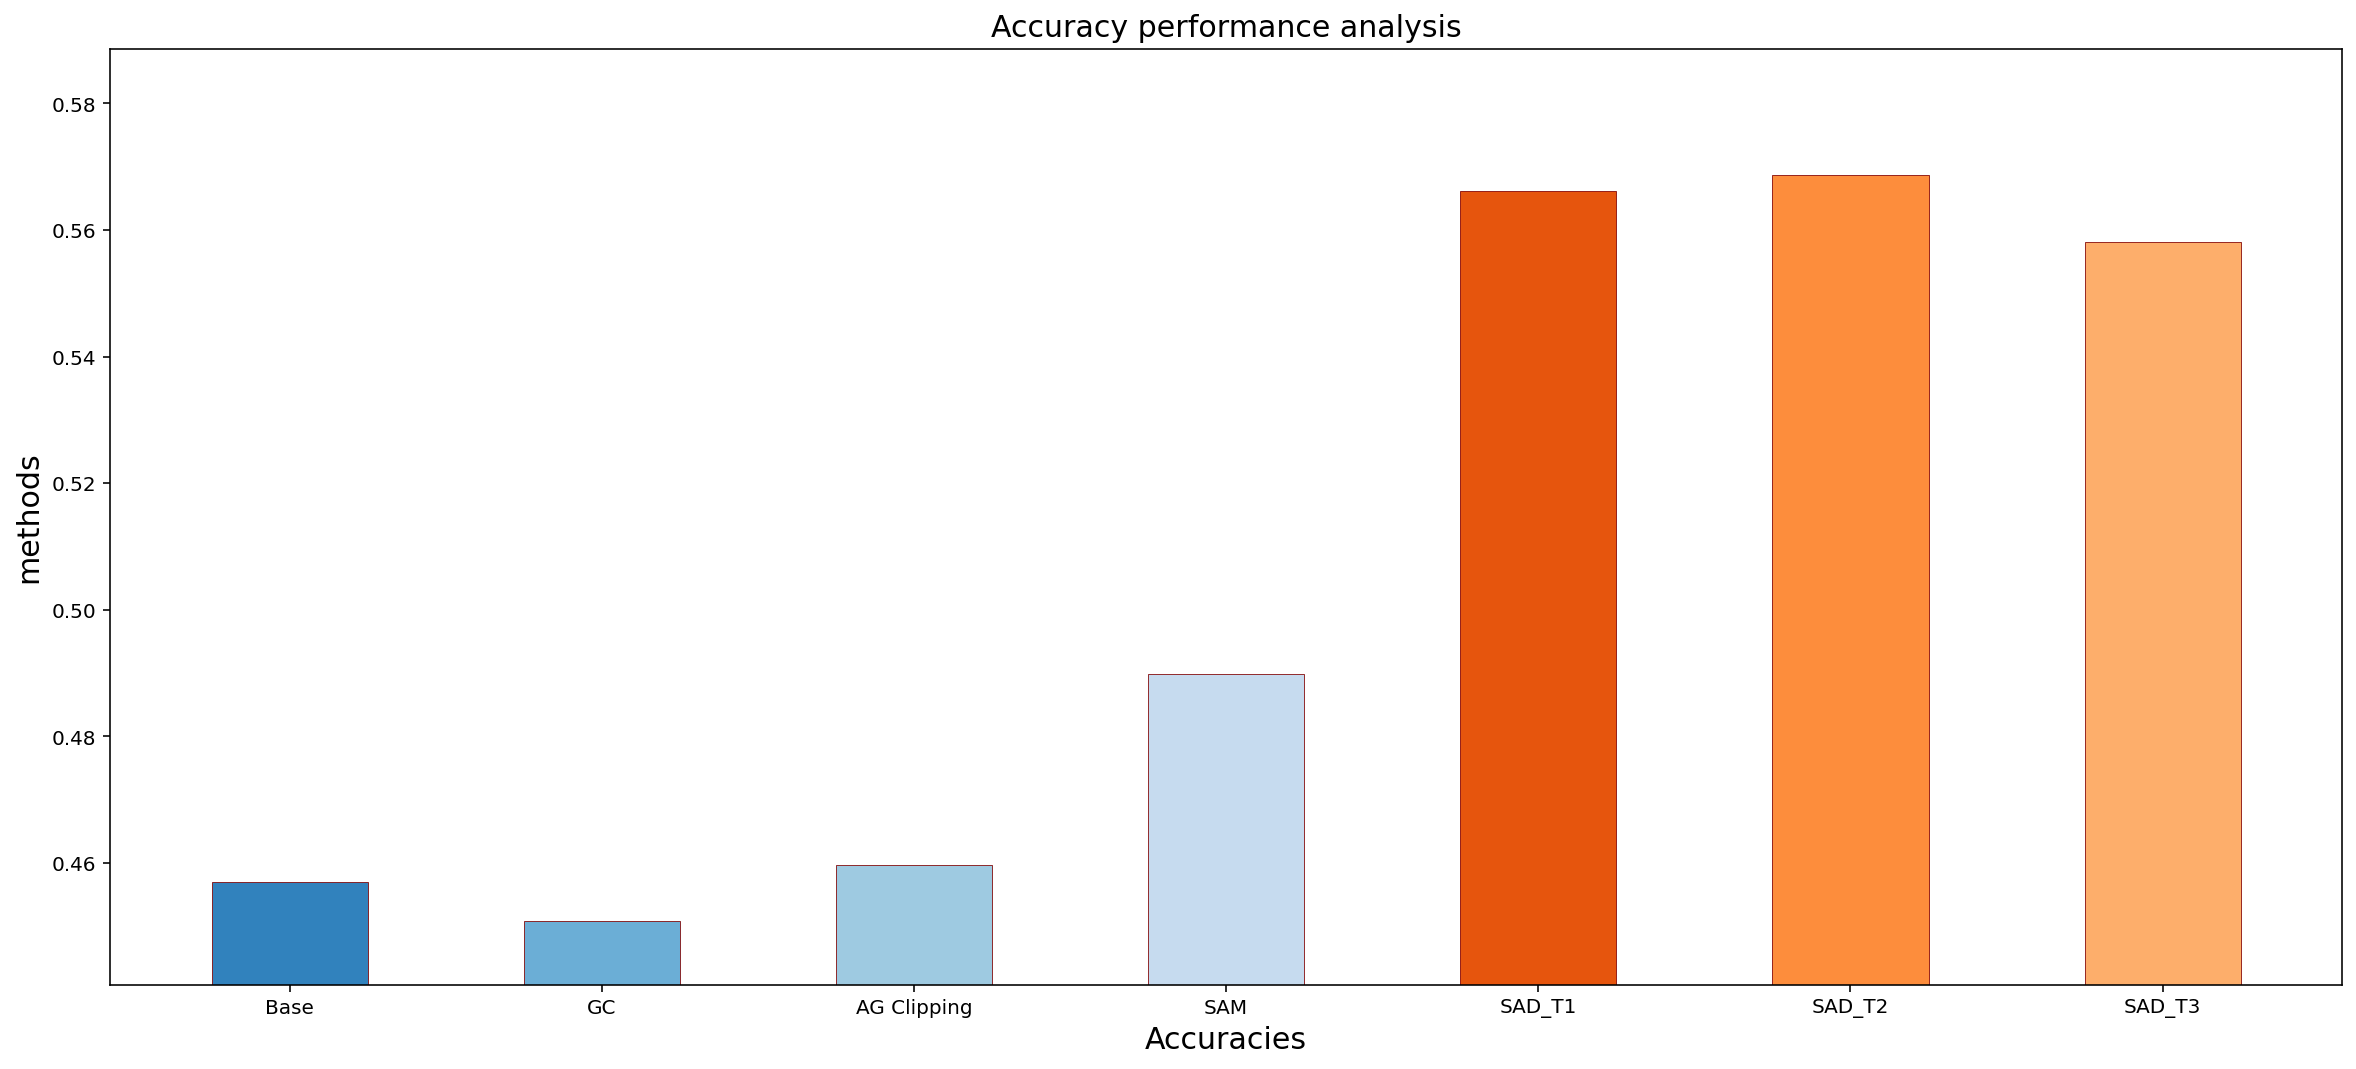

In [26]:
from matplotlib import pyplot as plt

# Visualizing the data
fig = plt.figure(figsize=(15.5, 6.5))
ax = fig.add_axes([0,0,1,1]) 
col_map = plt.get_cmap('tab20c')

# Creating a bar chart from a dictionary
plt.bar(hvo1, ac1, width=0.5, 
        color=col_map.colors, edgecolor='maroon', linewidth=.4)

plt.title('Accuracy performance analysis', fontsize=15)
plt.xlabel('Accuracies', fontsize=15)
plt.ylabel('methods', fontsize=15)

ax.set_ylim([np.min(ac1)-0.01, np.max(ac1)+0.02])
plt.show()

## save weights

In [27]:



# nvo1 = list()
# nvo1.append('VGG') #0
# nvo1.append('InceptionResNet')#1
# nvo1.append('Simple_cnn')#2
 
########### change here
# id2 = 1



# sample_dir = 'nips_weights/'+ nvo1[id2]+'_batch_size_'+str(bzs) 
# if not os.path.isdir(sample_dir):
#     os.makedirs(sample_dir)




# for i in range(len(hw)):
#     model.set_weights(hw[i][0])
#     model.save_weights(sample_dir+'/'+hvo1[i]+'.h5')